In first section, libraries and data are loaded, I created a repo and downloaded a datasets.

In [80]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler


In [81]:
books_df = pd.read_csv("data/Books.csv", low_memory=False)
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [82]:
ratings_df = pd.read_csv("data/Ratings.csv")
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [83]:
users_df = pd.read_csv("data/Users.csv")
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Here, exploratory data analysis (EDA)

In [84]:
ratings_df["ISBN"].value_counts()

ISBN
0971880107     2502
0316666343     1295
0385504209      883
0060928336      732
0312195516      723
               ... 
1568656386        1
1568656408        1
1569551553        1
1570081808        1
05162443314       1
Name: count, Length: 340556, dtype: int64

In [85]:
duplicates = books_df[books_df.duplicated(subset='ISBN', keep=False)]
print(duplicates[['ISBN', 'Book-Title']].sort_values('ISBN'))


Empty DataFrame
Columns: [ISBN, Book-Title]
Index: []


In [86]:
# Merge ratings with books to get titles
merged = ratings_df.merge(books_df[['ISBN', 'Book-Title']], on='ISBN', how='left')

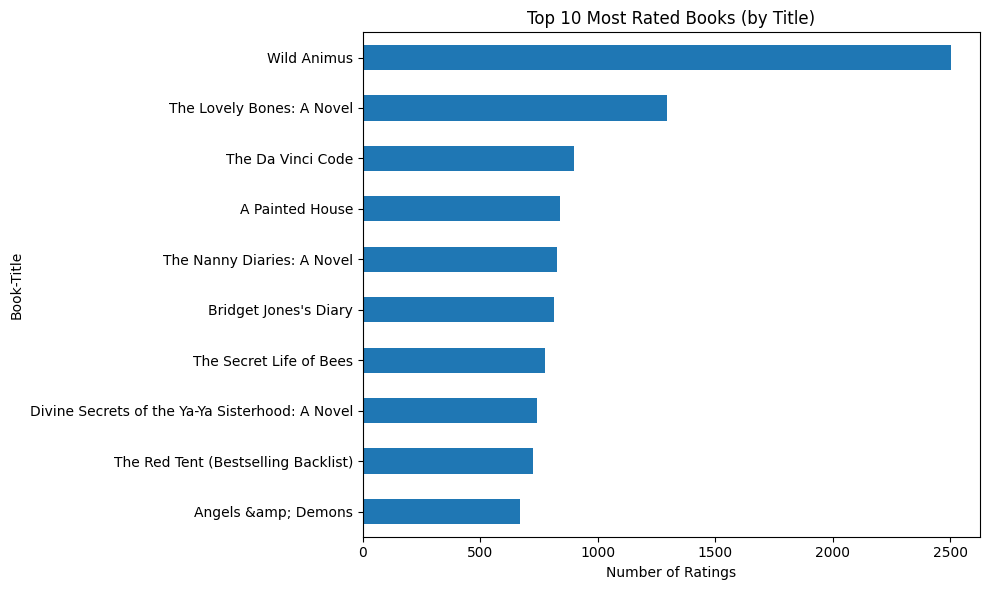

In [87]:
# Count ratings per title
top_titles = merged['Book-Title'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
top_titles.plot(kind='barh')
plt.title("Top 10 Most Rated Books (by Title)")
plt.xlabel("Number of Ratings")
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()


/var/folders/wn/y0pb2sm10lvg7s176rdg7yg80000gn/T/ipykernel_2628/3813032705.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('RdYlGn_r', 10)


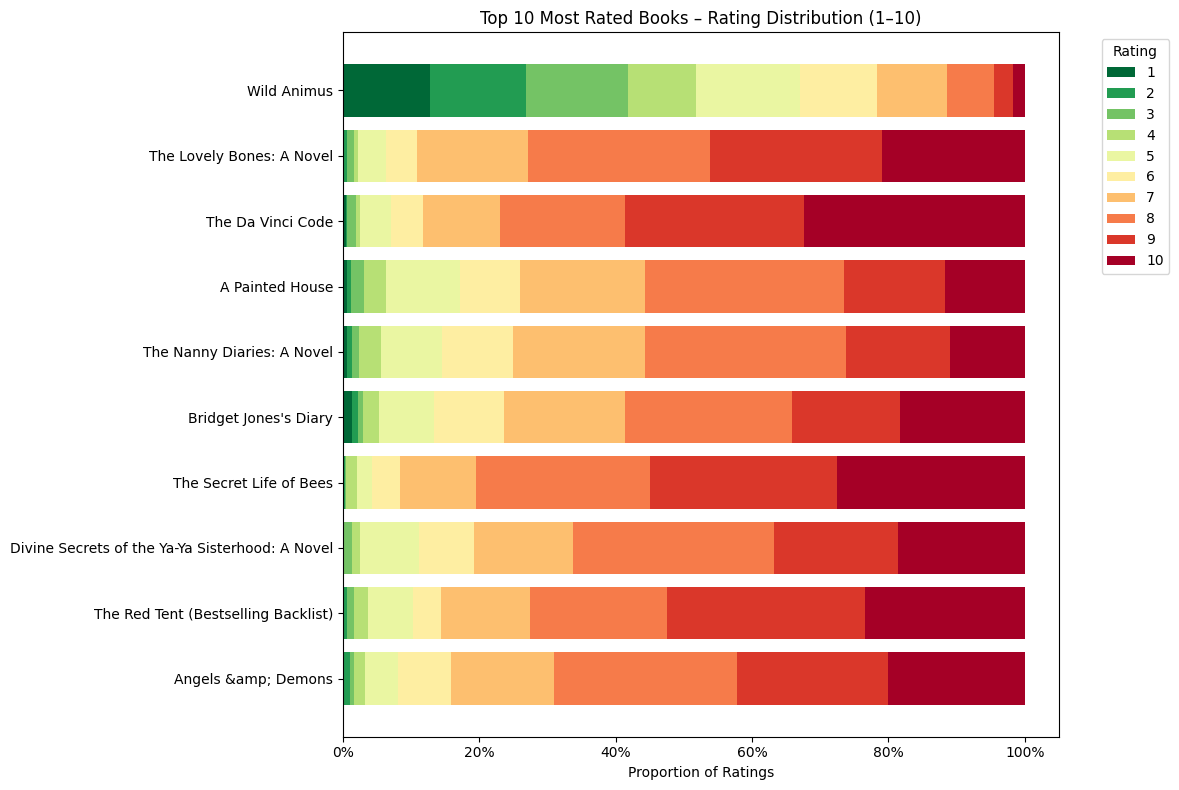

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

top_counts = merged['Book-Title'].value_counts().head(10)
top_titles = top_counts.index

rating_scale = list(range(1, 11))

dist = (
    merged[merged['Book-Title'].isin(top_titles)]
      .groupby('Book-Title')['Book-Rating']
      .value_counts()
      .unstack(fill_value=0)
      .reindex(columns=rating_scale, fill_value=0)
      .loc[top_titles]
)

prop = dist.div(dist.sum(axis=1), axis=0)

cmap = mpl.cm.get_cmap('RdYlGn_r', 10)
colors = [cmap(i) for i in range(cmap.N)]

plt.figure(figsize=(12, 8))
bottom = np.zeros(len(prop))

for rating_val, color in zip(rating_scale, colors):
    segment = prop[rating_val]
    plt.barh(prop.index, segment, left=bottom, color=color, label=str(rating_val))
    bottom += segment

plt.gca().invert_yaxis()
plt.xlabel('Proportion of Ratings')
plt.title('Top 10 Most Rated Books – Rating Distribution (1–10)')
plt.gca().set_xticks(np.linspace(0, 1, 6))
plt.gca().set_xticklabels([f'{int(x*100)}%' for x in np.linspace(0, 1, 6)])
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
